In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

In [2]:
%matplotlib inline

In [3]:
# Chargement des données clients et du dépôt depuis les fichiers Excel
df_clients = pd.read_excel('2_detail_table_customers.xls')
df_depot = pd.read_excel('4_detail_table_depots.xls')

In [4]:
# Extraction des informations pertinentes pour les clients
columns_clients = ["CUSTOMER_NUMBER", "CUSTOMER_LATITUDE", "CUSTOMER_LONGITUDE"]
data_clients = df_clients[columns_clients].rename(columns={"CUSTOMER_NUMBER": "number", "CUSTOMER_LATITUDE": "x", "CUSTOMER_LONGITUDE": "y"})
data_clients = data_clients.head(50)
NUM_CLIENTS=len(data_clients)

In [5]:
# Extraction des informations pertinentes pour le dépôt
depot_info = df_depot[['DEPOT_CODE', 'DEPOT_LATITUDE', 'DEPOT_LONGITUDE']].drop_duplicates()
depot_info = depot_info.rename(columns={"DEPOT_CODE": "number", "DEPOT_LATITUDE": "x", "DEPOT_LONGITUDE": "y"})

# Ajout du dépôt aux données clients
data_clients.loc[len(data_clients)] = depot_info.iloc[0]
data_clients[['x', 'y']] = data_clients[['x', 'y']]
# Constantes pour les positions des clients et du dépôt
DEPOT = (data_clients.iloc[-1]['x'], data_clients.iloc[-1]['y'])
client_positions = list(zip(data_clients['x'], data_clients['y']))

In [6]:
# Fonction pour calculer la distance euclidienne entre deux points
def distance(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

# Fonction pour évaluer la solution
def evaluate(solution):
    total_distance = 0
    current_location = DEPOT
    for client_idx in solution:
        client_position = client_positions[client_idx]
        total_distance += distance(current_location, client_position)
        current_location = client_position
    total_distance += distance(current_location, DEPOT)
    return total_distance


# Fonction pour initialiser une population
def initialize_population(population_size):
    return [random.sample(range(NUM_CLIENTS), NUM_CLIENTS) for _ in range(population_size)]

# Opérateur de sélection : sélection déterministe (les meilleurs individus sont choisis)
def selection(population, fitness):
    selected = []
    sorted_population = [x for _, x in sorted(zip(fitness, population))]
    for i in range(len(population) // 2):
        selected.append(sorted_population[i])
    return selected

# Opérateur de croisement : ordre partiel (partially matched crossover, PMX)
def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(NUM_CLIENTS), 2))
    child = [None] * NUM_CLIENTS
    # Copier la partie de parent1 dans la plage sélectionnée
    child[start:end] = parent1[start:end]
    # Compléter le reste avec les éléments de parent2 dans l'ordre
    for i in range(NUM_CLIENTS):
        if parent2[i] not in child:
            for j in range(NUM_CLIENTS):
                if child[j] is None:
                    child[j] = parent2[i]
                    break
    return child

# Fonction pour appliquer la mutation : permutation de deux clients
def mutate(solution):
    idx1, idx2 = random.sample(range(NUM_CLIENTS), 2)
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

# Fonction de l'algorithme génétique
def genetic_algorithm(population_size, generations):
    population = initialize_population(population_size)
    for _ in range(generations):
        print(_)
        fitness = [evaluate(individual) for individual in population]
        selected = selection(population, fitness)
        new_population = []
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(selected, k=2)
            child = crossover(parent1, parent2)
            if random.random() < 0.1:  # Chance de mutation
                child = mutate(child)
            new_population.append(child)
        population = new_population
    best_solution = min(population, key=evaluate)
    return best_solution, evaluate(best_solution)

# Exemple d'utilisation
best_solution, best_distance = genetic_algorithm(population_size=500, generations=500)
print("Meilleure solution:", best_solution)
print("Distance minimale:", best_distance)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

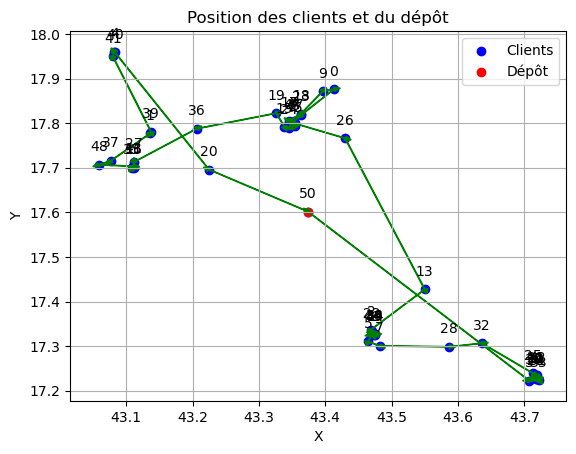

In [7]:
# Tracer les positions des clients et du dépôt
plt.scatter(*zip(*client_positions), color='blue', label='Clients')
plt.scatter(*DEPOT, color='red', label='Dépôt')
for i, (x, y) in enumerate(client_positions):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
current_location = DEPOT
for client_idx in best_solution:
    client_position = client_positions[client_idx]
    plt.arrow(current_location[0], current_location[1], client_position[0] - current_location[0],
              client_position[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')
    current_location = client_position
plt.arrow(current_location[0], current_location[1], DEPOT[0] - current_location[0],
          DEPOT[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position des clients et du dépôt')
plt.grid(True)
plt.show()


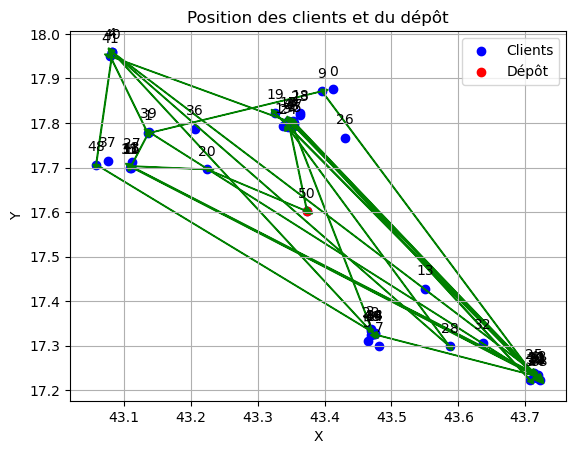

In [11]:

best_solution=[51, 18, 46, 34, 40, 12, 13, 7, 25, 29, 41, 49, 35, 23, 15, 11, 20, 30, 48, 4, 9, 42, 2, 10, 31, 26, 45, 50, 5, 43, 44, 21, 51]
# Tracer les positions des clients et du dépôt
plt.scatter(*zip(*client_positions), color='blue', label='Clients')
plt.scatter(*DEPOT, color='red', label='Dépôt')
for i, (x, y) in enumerate(client_positions):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,10), ha='center')
current_location = DEPOT
for client_idx in best_solution:
    client_position = client_positions[client_idx-1]
    plt.arrow(current_location[0], current_location[1], client_position[0] - current_location[0],
              client_position[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')
    current_location = client_position
plt.arrow(current_location[0], current_location[1], DEPOT[0] - current_location[0],
          DEPOT[1] - current_location[1], head_width=0.01, head_length=0.01, fc='green', ec='green')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position des clients et du dépôt')
plt.grid(True)
plt.show()
